# **CREDIT CARD FRAUD DETECTION USING TransformerClassifer, Bayesian Neural Network, Convulational Neural Network to see which ML model gives accurate predictions**

The dataset downloaded from www.kaggle.com, consists of credit card transactions made by European cardholders occurring within two days in September 2013, where it has 492 frauds out of 284,807 transactions. It consists of 31 features including the time when a transaction took place, the amount of transactions, and 28 other attributes labeled from V1 to V28 and the target label ‘Class’ which decides if a transaction is fraudulent or not by a binary value ‘1’ and ‘0’ respectively.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
!gdown 1v8QFTF8kDzkEp4oIKH-AEqWj1hYBNIJ9 # dataset creditcard.csv is shared from the gdrive
data = pd.read_csv('/content/creditcard.csv')
X = data.drop('Class', axis=1)
y = data['Class']

Downloading...
From (original): https://drive.google.com/uc?id=1v8QFTF8kDzkEp4oIKH-AEqWj1hYBNIJ9
From (redirected): https://drive.google.com/uc?id=1v8QFTF8kDzkEp4oIKH-AEqWj1hYBNIJ9&confirm=t&uuid=064d7e21-ed01-476e-95b1-f838a14dfd00
To: /content/creditcard.csv
100% 151M/151M [00:08<00:00, 17.9MB/s]


In [ ]:
scaler = StandardScaler() # normalization
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

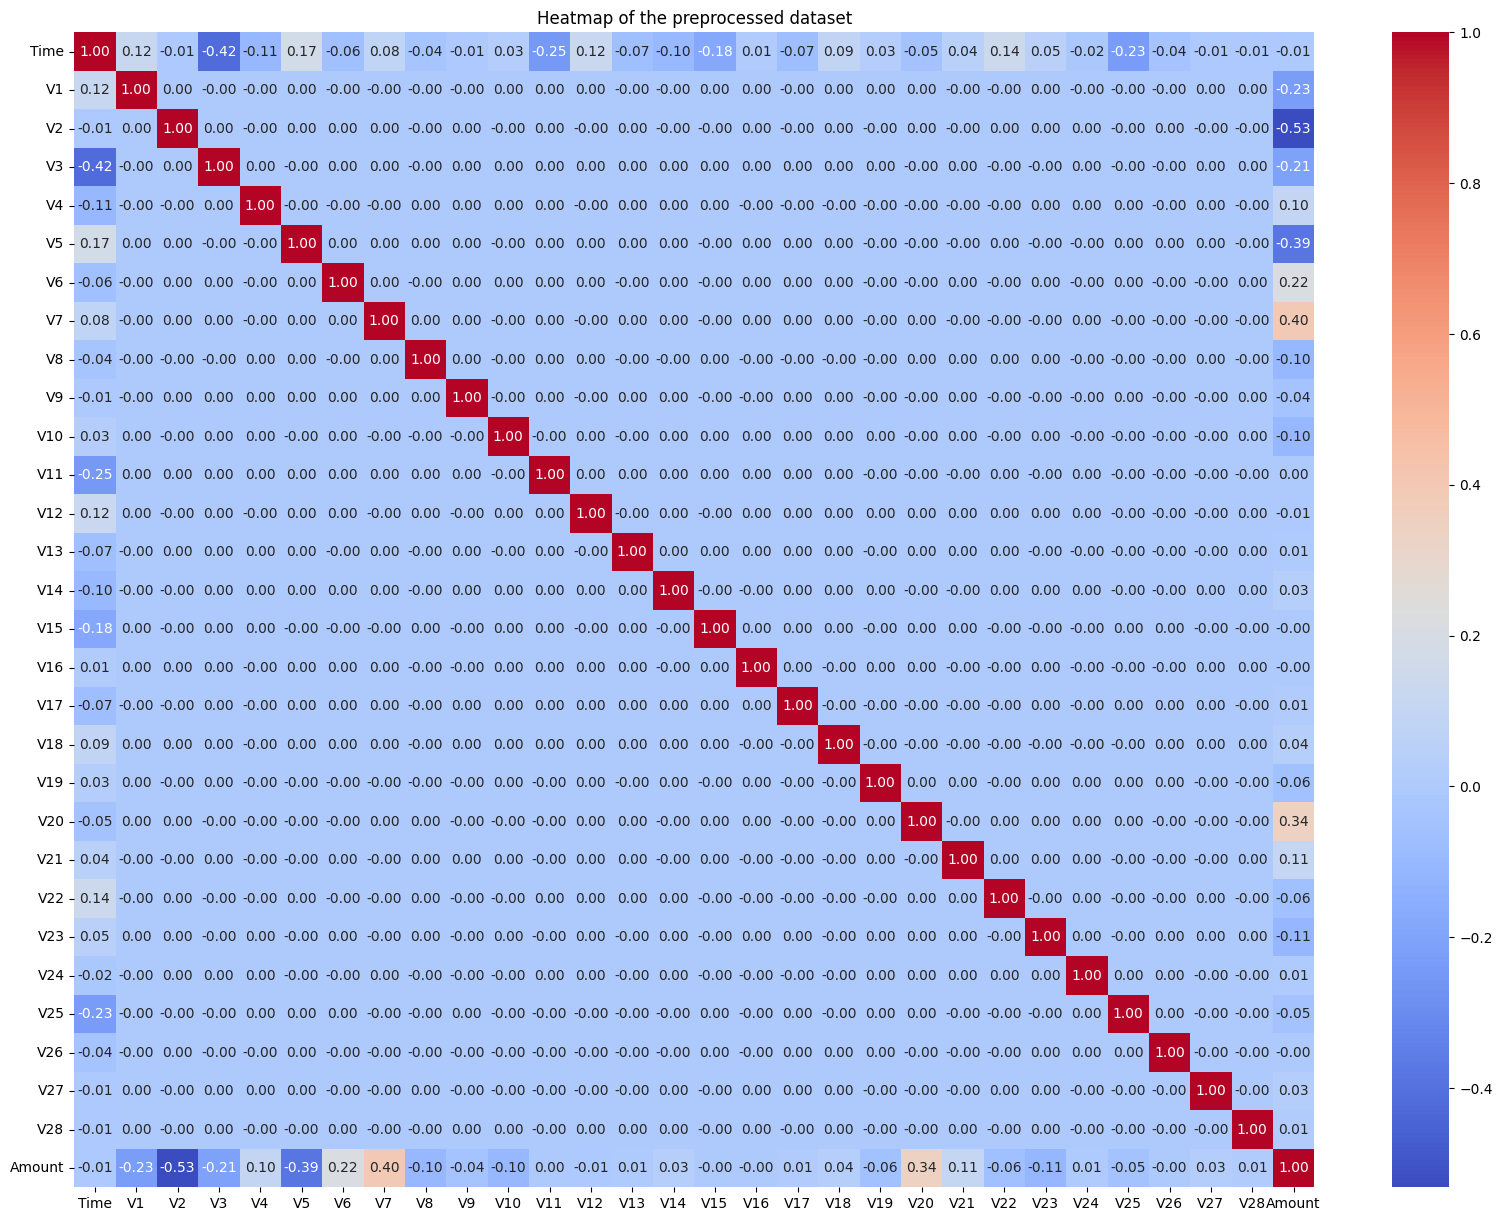

In [ ]:

plt.figure(figsize=(20, 15))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of the preprocessed dataset')
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1) # 'n_estimators' hyperparameter represents the number N of tree

rf.fit(X_train, y_train) # model fitting

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [ ]:
feature_importances = rf.feature_importances_ # feature importance will decide which feature is more crucial in classufying transactions

feature_importances_scaled = feature_importances / feature_importances.sum()

feature_weights = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances_scaled
})

feature_weights = feature_weights.sort_values(by='Importance', ascending=False) # features sorted by their imp.

print(feature_weights)


   Feature  Importance
17     V17    0.185321
12     V12    0.152359
14     V14    0.144578
16     V16    0.084522
10     V10    0.075984
11     V11    0.063671
9       V9    0.038423
18     V18    0.027540
7       V7    0.023277
4       V4    0.021741
21     V21    0.018703
26     V26    0.018370
3       V3    0.014575
20     V20    0.010100
6       V6    0.009837
27     V27    0.009052
5       V5    0.008899
28     V28    0.008760
1       V1    0.008727
2       V2    0.008551
8       V8    0.008223
29  Amount    0.008103
15     V15    0.008082
19     V19    0.007438
0     Time    0.007246
22     V22    0.006859
24     V24    0.006088
13     V13    0.005631
25     V25    0.005364
23     V23    0.003976


In [ ]:
# features scaled down
X_train_scaled = X_train.mul(feature_importances_scaled, axis=1)
X_test_scaled = X_test.mul(feature_importances_scaled, axis=1)


# datasets --> pyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.values).float()
X_test_tensor = torch.tensor(X_test_scaled.values).float()
y_train_tensor = torch.tensor(y_train.values).long()
y_test_tensor = torch.tensor(y_test.values).long()

In [ ]:
batch_size = 1000 # change this for Transformers' batch size

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, num_features, num_classes, num_heads, num_layers, dropout):
        super(TransformerClassifier, self).__init__()
        embed_dim = num_heads * (num_features // num_heads + (num_features % num_heads > 0))
        self.embedding = nn.Linear(num_features, embed_dim)
        self.transformer = nn.Transformer (
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.embedding(x)
        x = self.transformer(x, x)
        x = x.mean(dim=1)  # avg pooling along the sequence length
        x = self.fc(x)
        return x

In [ ]:
class BayesianNN(nn.Module):
    def __init__(self, num_features, num_classes, dropout_rate=0.5):
        super(BayesianNN, self).__init__()
        self.linear1 = nn.Linear(num_features, 512)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(512, num_classes)

    def forward(self, x, apply_dropout=True):
        x = self.relu(self.linear1(x))
        if apply_dropout:
            x = self.dropout(x)
        x = self.linear2(x)
        return x

In [ ]:
class ConvolutionalNN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(ConvolutionalNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, padding=1)  # treating features as one-dimensional
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()

        pooled_output_size = num_features // 4 * 64  # divide by 4 because of two pooling layers each with pool size 2
        self.linear = nn.Linear(pooled_output_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

In [ ]:
def train_and_evaluate(model, train_loader, test_loader, num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            input_features, labels = batch
            input_features, labels = input_features, labels
            optimizer.zero_grad()
            output = model(input_features)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: loss {total_loss / len(train_loader)}")

    model.eval()
    total_accuracy = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_features, labels = batch
            input_features, labels = input_features, labels
            output = model(input_features)
            predicted_classes = output.argmax(dim=1)
            total_accuracy += (predicted_classes == labels).float().mean().item()
            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_predictions, average='binary')
    recall = recall_score(all_labels, all_predictions, average='binary')
    f1 = f1_score(all_labels, all_predictions, average='binary')
    print(f'Average Test Accuracy: {total_accuracy / len(test_loader)}')
    print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

    return {
        'accuracy': total_accuracy / len(test_loader),
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [ ]:
trf = TransformerClassifier(num_features=X_train_scaled.shape[1], num_classes=2, num_heads=1, num_layers=2, dropout=0.1)
bnn = BayesianNN(X_train_scaled.shape[1], 2)
cnn = ConvolutionalNN(X_train_scaled.shape[1], 2)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# print("for Transformer Classifier, ")
# train_and_evaluate(trf, train_loader)

In [ ]:
# print("for Bayesian Neural Network, ")
# train_and_evaluate(bnn, train_loader)

In [ ]:
# print("for Convulational Neural Network, ")
# train_and_evaluate(cnn, train_loader)

In [ ]:
results = []
models = {
    'TransformerClassifier': trf,
    'BayesianNN': bnn,
    'ConvulationalNN': cnn
}

for name, model in models.items():
    print(f"Training and evaluating {name}")
    metrics = train_and_evaluate(model, train_loader, test_loader)
    results.append({
        'Model': name,
        **metrics
    })

results_df = pd.DataFrame(results)
print(results_df)


Training and evaluating TransformerClassifier


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: loss 0.0034825238717894535
Epoch 2: loss 0.003618652026016207
Epoch 3: loss 0.0035065722417493817
Epoch 4: loss 0.003458315484240302
Epoch 5: loss 0.0034366661715466763
Epoch 6: loss 0.003478442672530946
Epoch 7: loss 0.003302767482455238
Epoch 8: loss 0.0033419452483940404
Epoch 9: loss 0.0034364368852766347
Epoch 10: loss 0.0033607610466424376
Average Test Accuracy: 0.9993604712708052
Precision: 0.7793103448275862, Recall: 0.8308823529411765, F1 Score: 0.8042704626334519
Training and evaluating BayesianNN


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: loss 0.0031622544592391933
Epoch 2: loss 0.0032291780896048293
Epoch 3: loss 0.003185662834512186
Epoch 4: loss 0.003097517571004573
Epoch 5: loss 0.0031721110935905017
Epoch 6: loss 0.0030399840247264365
Epoch 7: loss 0.0030925941540044734
Epoch 8: loss 0.002987096038123127
Epoch 9: loss 0.0030069993831421016
Epoch 10: loss 0.0030404929805808935
Average Test Accuracy: 0.9995465167733126
Precision: 0.8818897637795275, Recall: 0.8235294117647058, F1 Score: 0.8517110266159696
Training and evaluating ConvulationalNN


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: loss 0.0034563713833631483
Epoch 2: loss 0.003457728450302966
Epoch 3: loss 0.0033740813054464525
Epoch 4: loss 0.0034129093697993084
Epoch 5: loss 0.0033156684839559603
Epoch 6: loss 0.0033261457046319266
Epoch 7: loss 0.0033508696877834155
Epoch 8: loss 0.0033744957188901028
Epoch 9: loss 0.003331623017365928
Epoch 10: loss 0.003289024923069519
Average Test Accuracy: 0.9995232612587684
Precision: 0.8740157480314961, Recall: 0.8161764705882353, F1 Score: 0.844106463878327
                   Model  accuracy  precision    recall  f1_score
0  TransformerClassifier  0.999360   0.779310  0.830882  0.804270
1             BayesianNN  0.999547   0.881890  0.823529  0.851711
2        ConvulationalNN  0.999523   0.874016  0.816176  0.844106


# Accuracy of all the ML models are greater than 99.9% with high precision, recall and F1 score.

**Overall, the choice of model might depend on what metric is most critical for the application. The BayesianNN looks favorable if avoiding false positives is crucial. If capturing as many positives as possible is important, the TransformerClassifier could be preferable. If a balance between precision and recall is important, Convulational Neural Network is preferable.**



